In [1]:
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/h5py/tests/old/test_attrs_data.py:251: DeprecationWarning: invalid escape sequence \H
  s = b"Hello\x00\Hello"
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/sklearn/__init__.py:22: DeprecationWarning: invalid escape sequence \.
  module='^{0}\.'.format(re.escape(__name__)))
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/scipy/_lib/_numpy_compat.py:287: DeprecationWarning: invalid escape sequence \p
  """
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/func_inspect.py:53: DeprecationWarning: invalid escape sequence \<
  '\<doctest (.*\.rst)\[(.*)\]\>', source_file).groups()
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_memory_helpers.py:10: DeprecationWarning: invalid escape sequence \s
  cookie_re = re.compile("coding[:=]\s*([-\w.]+)")


In [2]:
ctx = mx.cpu()

In [3]:
def transform(data, label):
    return data.astype(np.float32) / 255, label.astype(np.float32)

In [4]:
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

In [5]:
image, label = mnist_train[0]
print(image.shape, label)

(28, 28, 1) 5.0


In [6]:
num_inputs = 784
num_outputs = 10

In [7]:
im = mx.nd.tile(image, (1, 1, 3))
print(im.shape)

(28, 28, 3)


/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:550: DeprecationWarning: invalid escape sequence \*
  """
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:1126: DeprecationWarning: invalid escape sequence \S
  _find_dedent_regex = re.compile("(?:(?:\n\r?)|^)( *)\S")
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:1961: DeprecationWarning: invalid escape sequence \m
  """
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/pyparsing.py:131: DeprecationWarning: invalid escape sequence \d
  xmlcharref = Regex('&#\d+;')
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/pyparsing.py:2127: DeprecationWarning: invalid escape sequence \g
  ret = re.sub(self.escCharReplacePattern,"\g<1>",ret)
/home/chuanleiguo/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:265: DeprecationWarning: invalid escape sequence \A
  hexColorPattern = re.compile("\A#[a-fA-F0-9]{6}\Z")
/home/chuanleiguo/anaconda3/lib

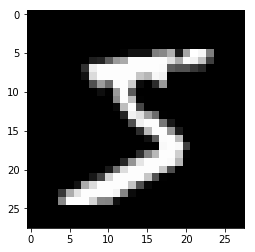

In [8]:
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

In [9]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)

In [10]:
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [11]:
W = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)

params = [W, b]

In [12]:
for param in params:
    param.attach_grad()

In [14]:
def softmax(y_linear):
    exp = nd.exp(y_linear - nd.max(y_linear))
    norms = nd.sum(exp, axis=0, exclude=True).reshape((-1, 1))
    return exp / norms

In [15]:
sample_y_linear = nd.random_normal(shape=(2, 10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[ 0.01466005  0.03104205  0.09487285  0.11615293  0.07316667  0.01516553
   0.44094777  0.08199082  0.0917872   0.04021411]
 [ 0.0309542   0.07588483  0.37230074  0.03313261  0.0499984   0.13276106
   0.14566724  0.02354518  0.08515968  0.05059606]]
<NDArray 2x10 @cpu(0)>


In [16]:
print(nd.sum(sample_yhat, axis=1))


[ 1.  1.]
<NDArray 2 @cpu(0)>


In [17]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

In [18]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

In [19]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [20]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=-1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [21]:
evaluate_accuracy(test_data, net)

0.079499997

In [22]:
epochs = 10
moving_loss = 0.
learning_rate = .001
smoothing_constant = .01
niter=0

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, est_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.32932401929, Train_acc 0.7555, Test_acc 0.766
Epoch 1. Loss: 0.977667200022, Train_acc 0.81215, Test_acc 0.8204
Epoch 2. Loss: 0.809557151644, Train_acc 0.836, Test_acc 0.8431
Epoch 3. Loss: 0.711106824243, Train_acc 0.849233, Test_acc 0.8578
Epoch 4. Loss: 0.663962293751, Train_acc 0.858583, Test_acc 0.8656
Epoch 5. Loss: 0.607308888513, Train_acc 0.865283, Test_acc 0.8705
Epoch 6. Loss: 0.592547143782, Train_acc 0.870533, Test_acc 0.8759
Epoch 7. Loss: 0.553879088623, Train_acc 0.874617, Test_acc 0.8789
Epoch 8. Loss: 0.534050706312, Train_acc 0.877583, Test_acc 0.8821
Epoch 9. Loss: 0.517923389092, Train_acc 0.881017, Test_acc 0.8834


(10, 28, 28, 1)


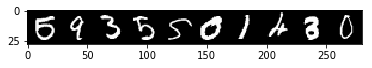

model predictions are: 
[ 5.  4.  3.  3.  5.  0.  1.  2.  8.  5.]
<NDArray 10 @cpu(0)>


In [23]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break